This notebook recreates our TTCT Figural classification on the MTCI data from the recent AuDrA paper.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install transformers datasets evaluate wandb

See the image classification [task page](https://huggingface.co/tasks/image-classification) for more information about its associated models, datasets, and metrics.

In [ ]:
from datasets import load_dataset, Image, Dataset, DatasetDict
from transformers import DefaultDataCollator, AutoImageProcessor
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

import torch.nn.functional as f
import torch

import wandb
import pandas as pd
import numpy as np
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: porg (massive-texts). Use `wandb login --relogin` to force relogin


True

## Prep the data

Some comments:
- ViT and BEiT have a base size (86M) and a large size (307M).
   - in the [BEiT](https://arxiv.org/pdf/2106.08254.pdf) paper, B>L tends to be 2-2.5pt improvement for both BEiT and ViT. (Table 1)
- regular resolution of ViT, BEiT, ConvNext is 224. VIT and BEiT also have resolution of 384.
   - In the BEiT paper, 224>384 is about 1-1.5pt improvement for both models.
   - I expect that for doodles, the improvment will be lower.
- Most common training data is ImageNet 1k and ImageNet-22k.

In [ ]:
wd = Path('/content/drive/MyDrive/Projects/motes-figural')
project_data_dir = wd / 'data'
#img_dir = wd / 'extracted_content'
#gt_dir = wd / 'img_ground_truth'

seed = 1234 #@param {type:"integer"}
name = "motes_mtci" #@param {type:"string"}
classification_model = "microsoft/beit-large-patch16-224-pt22k-ft22k" #@param ["google/vit-large-patch16-224", "microsoft/beit-large-patch16-224-pt22k-ft22k", "facebook/convnext-base-224", "microsoft/resnet-50", "google/vit-base-patch16-384", "microsoft/beit-base-patch16-224-pt22k-ft22k", "google/vit-base-patch16-224"]
%env WANDB_PROJECT=$name

modeldir = project_data_dir / 'models' / (name+'_'+classification_model.replace('/','-'))
modeldir.mkdir(exist_ok=True)


env: WANDB_PROJECT=motes_mtci


### General Prep

In [ ]:
data_dir = Path('/content/drive/MyDrive/data/others/audra')

In [ ]:
# doublecheck that this is the analysis data
collector = []
for csvfile in (data_dir / 'Analysis').glob('*csv'):
    x = pd.read_csv(csvfile)
    x['dataset'] = csvfile.stem.split('_')[0]
    collector.append(x)
analysis_data = pd.concat(collector)
analysis_data.groupby('dataset').corr().iloc[1::2, 0].round(2)

dataset                
fargen      predictions    0.47
rg1         predictions    0.76
rg2         predictions    0.64
test        predictions    0.93
validation  predictions    0.81
Name: ratings, dtype: float64

The data above matches the paper. The numbers above are errenous - I found a bug on replication which inflated the results from $r=.79$ to $r=.93$, but this at least confirms that I'm looking at the right data.

THe exactly train/val/test splits in the AuDrA paper were shared, so I'll randomize my own split.

In [ ]:
scaler = MinMaxScaler()
collector = []
# JRT uses the judge response theory data
for csvfile in (data_dir / 'Ratings/JRT').glob('*csv'):
    x = pd.read_csv(csvfile, names=['ID', 'score'])
    x['dataset'], x['style'] = csvfile.stem.split('_')
    collector.append(x)
jrt_data = pd.concat(collector)
display(jrt_data.dataset.value_counts())
jrt_data.sample(2)

jrt_data['score_norm'] = scaler.fit_transform(jrt_data.score.values.reshape(-1, 1))[:,0]

jrt_data.sample(1)

primary    11075
rg2          722
fg           679
rg1          670
Name: dataset, dtype: int64

,ID,score,dataset,style,score_norm
100,101_13,-1.440692,primary,jrt,0.255827


In [ ]:
# download images - rather than accessing from GDrive, for faster read downstream (I hope!)
download = True
if download:
    if not Path('drawings.zip').exists():
        !wget -O drawings.zip https://osf.io/download/9bu3a/
    !unzip -u drawings.zip
    drawings = Path('/content/AuDrA Drawings').glob('**/*jpg')
else:
    drawings = (data_dir / 'drawings').glob('**/*jpg')

Archive:  drawings.zip


In [ ]:
rows = []
dataset_key = {'primary_images': 'primary', 'rater_generalization_one_images':'rg1',
                'rater_generalization_two_images':'rg2', 'far_generalization_images':'fg'}
for impath in drawings:
    rows.append(dict(img_path=impath,
                     ID=impath.stem,
                     activity=impath.parent.stem,
                     dataset=dataset_key[impath.parent.parent.stem]
                     )
    )

imdata = pd.DataFrame(rows)
data = jrt_data.merge(imdata)
# id-encode activity
activities = data['activity'].unique().tolist()
id2activity = {i:x for i, x in enumerate(activities)}
activity2id = {x:i for i, x in enumerate(activities)}
data['activity_id'] = data.activity.replace(activity2id)
data.sample()

,ID,score,dataset,style,score_norm,img_path,activity,activity_id
6047,3977_7,-0.549785,primary,jrt,0.399798,/content/AuDrA Drawings/primary_images/Images_...,Images_7,3


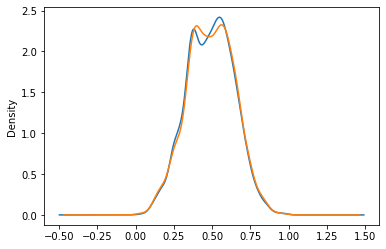

In [ ]:
# compare dist of test/val data to all data
ax= jrt_data[jrt_data.dataset == 'primary'].score_norm.plot(kind='density')
analysis_data[analysis_data.dataset.isin(['test', 'validation'])].ratings.plot(kind='density', ax=ax)

In [ ]:
rng = np.random.default_rng(seed=seed)
val_prop = 0.1
test_prop = 0.2

data['split'] = 'train'
just_primary = data.dataset == 'primary'
randv = rng.random(size=len(data))
randv[~just_primary] = 0

data.loc[(randv < test_prop+val_prop), 'split'] = 'val'
data.loc[(randv < test_prop), 'split'] = 'test'

data.groupby(['dataset']).split.apply(lambda x: x.value_counts() / len(x)).round(2)

dataset       
fg       test     1.0
primary  train    0.7
         test     0.2
         val      0.1
rg1      test     1.0
rg2      test     1.0
Name: split, dtype: float64

In [ ]:
# Create dataset
datasets = {}
for split in ['test', 'train', 'val']:
    subset = data[(data.split == split) & (data.dataset == 'primary')]
    datasets[split] = Dataset.from_dict({'image': subset.img_path.astype(str),
                                         'activity': subset.activity_id.astype(int),
                                         'label': subset.score_norm}).cast_column("image", Image()).shuffle(seed=seed)

rawdataset = DatasetDict(datasets)
rawdataset

DatasetDict({
    test: Dataset({
        features: ['image', 'activity', 'label'],
        num_rows: 2191
    })
    train: Dataset({
        features: ['image', 'activity', 'label'],
        num_rows: 7796
    })
    val: Dataset({
        features: ['image', 'activity', 'label'],
        num_rows: 1088
    })
})

### Model-Specific Prep

Transformations and normalization

In [ ]:
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, Resize, Compose, Normalize, ToTensor, RandomInvert
import warnings

one_hot = False #@param {type:"boolean"}
if one_hot:
    warnings.warn("The current one-hot strategy likely won't make a difference because of the patches in VITs. A better strategy would be to change the token in the feature extraction")
invert_prob = 0.5 #@param {type:"slider", min:0, max:1, step:0.5}
random_crop = False #@param {type:"boolean"}
random_hflip = False #@param {type:'boolean'}

image_processor = AutoImageProcessor.from_pretrained(classification_model)
if "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
else:
    size = (image_processor.size["height"], image_processor.size["width"])
print("image size:", size)

pipeline = []
normalize = Normalize(mean=image_processor.image_mean,
                      std=image_processor.image_std)

if random_crop:
    pipeline.append(RandomResizedCrop(size))
else:
    pipeline.append(Resize(size))

if random_hflip:
    pipeline.append(RandomHorizontalFlip(p=0.5))

if invert_prob > 0:
    pipeline.append(RandomInvert(p=invert_prob)) # possibly force it to look for signal beyond ink

pipeline += [ToTensor(), normalize]
_transforms = Compose(pipeline)

def one_hot_pad(input):
    pixel_values, activity = input
    pixel_values[:, :len(activities), 0] = f.one_hot(torch.tensor(activity), num_classes=len(activities))
    return pixel_values

one_hot_transform = Compose([one_hot_pad])

def transforms(examples, one_hot=False):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    if one_hot:
        examples["pixel_values"] = [one_hot_transform((px, act)) for px, act in zip(examples['pixel_values'], examples['activity'])]
    del examples["image"]
    del examples['activity']
    return examples

dataset = rawdataset.with_transform(lambda x: transforms(x, one_hot))

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


image size: (224, 224)


## Train

In [ ]:
import numpy as np
import evaluate
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback

In [ ]:
mse = evaluate.load("mse")
pearson = evaluate.load("pearsonr")
# other possibilities - mae, matthews_correlation

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    metrics = {}
    for metric in [mse, pearson]:
        metrics.update(metric.compute(predictions=logits, references=labels))
    return metrics

In [ ]:
# Init model
model = AutoModelForImageClassification.from_pretrained(
    classification_model,
    num_labels=1,
    ignore_mismatched_sizes=True # without this, it has the original classifier's n(classes) from ImageNet
)

Downloading:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([1, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
epochs = 25
log_times_per_epoch = 5 # approx. used to set logging_steps

# this is based off the observed limit with my own gpu
if ('384' in classification_model) or ("large" in classification_model):
    # beit-large-224 and vit-large-224 have 307m params, whereas their base models have 86m
    # https://arxiv.org/pdf/2106.08254.pdf
    batch_size = 22
    gradient_accumulation_steps = 8
elif 'convnext-base-224' in classification_model:
    batch_size = 48
    gradient_accumulation_steps = 4
elif '224' in classification_model:
    batch_size = 64
    gradient_accumulation_steps = 4
else:
    batch_size = 16
    gradient_accumulation_steps = 4

wandb.init(project=name)
wandb.config.update({'one-hot':one_hot,
                     'classification_model':classification_model,
                     'seed':seed,
                     'invert_prob':invert_prob,
                     'random_crop':random_crop,
                     'random_hflip': random_hflip})

data_collator = DefaultDataCollator() # a basic data collator for batching
training_args = TrainingArguments(
    output_dir=str(modeldir),
    remove_unused_columns=False,
    evaluation_strategy="epoch", # perhaps change to 'steps' and use eval_steps?

    save_strategy="epoch", 
    #save_steps=120, for save_strategy = 'steps'
    save_total_limit=3, #deletes oldest checkpoints

    learning_rate= 5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.2, #0.1, #% of total steps to warm up (higher is slower)
    
    num_train_epochs=epochs,
    logging_steps = int(dataset['train'].num_rows/batch_size/gradient_accumulation_steps//log_times_per_epoch),
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=False, 
    push_to_hub=False, # true if you want to share
    report_to='wandb',
    run_name=modeldir.name
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 5)]
)

trainer.train()

In [ ]:
predictions, label_ids, metrics = trainer.predict(dataset['test'], metric_key_prefix='test')
metrics = {k.replace('test_', 'test/'):v for k,v in metrics.items()}
wandb.log(metrics)
print(metrics)

***** Running Prediction *****
  Num examples = 2191
  Batch size = 16


{'test/loss': 0.005960000678896904, 'test/mse': 0.005960000530483946, 'test/pearsonr': 0.8634577765520541, 'test/runtime': 93.3034, 'test/samples_per_second': 23.483, 'test/steps_per_second': 1.468}


| Model         | Epochs     | MSE | R | Link |
|---------------|-----------|------|-----|---|
| google/vit-base-patch16-384 | 7 | 0.010418 | 0.759714 | [WandB](https://wandb.ai/massive-texts/motes_mtci/runs/zohzbksf?workspace=user-porg)


## Inference

Example of using the model, in a `pipeline`:

In [ ]:
# load example image
image = dataset['test']
image[0]

In [ ]:
from transformers import pipeline
path_to_model = "test_model"

classifier = pipeline("image-classification", model=path_to_model)
classifier(image)

[{'score': 0.35574808716773987, 'label': 'beignets'},
 {'score': 0.018057454377412796, 'label': 'chicken_wings'},
 {'score': 0.017733804881572723, 'label': 'prime_rib'},
 {'score': 0.016335085034370422, 'label': 'bruschetta'},
 {'score': 0.0160061065107584, 'label': 'ramen'}]

Or manually, rather than via pipeline:

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch

image_processor = AutoImageProcessor.from_pretrained(path_to_model)
inputs = image_processor(image, return_tensors="pt") # return as pytorch

model = AutoModelForImageClassification.from_pretrained(path_to_model)
with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]